1) 데이터 준비와 확인

In [2]:
import numpy as np
import tensorflow as tf
import os
import pandas as pd
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

In [3]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


2) 데이터로더 구성

데이터의 중복 제거

NaN 결측치 제거

한국어 토크나이저로 토큰화

불용어(Stopwords) 제거

사전word_to_index 구성

텍스트 스트링을 사전 인덱스 스트링으로 변환

X_train, y_train, X_test, y_test, word_to_index 리턴

In [4]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]
#여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

3) 모델 구성을 위한 데이터 분석 및 가공

In [7]:
print(X_train[0])
print('라벨: ', y_train[0])
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [8]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(round(np.sum(num_tokens < max_tokens) / len(num_tokens)*100, 2) ))


문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 93.43%가 maxlen 설정값 이내에 포함됩니다. 


In [9]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index['<PAD>'],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

In [10]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  41.0
문장길이 최대 :  41
문장길이 표준편차 :  0.0
pad_sequences maxlen :  41
전체 문장의 0.0%가 maxlen 설정값 이내에 포함됩니다. 


4) 모델 구성 및 validation set 구성

In [11]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [12]:
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
vector = word2vec['computer']
vector     

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [13]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [14]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 300)           3000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            33616     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

5) 모델 훈련 개시

In [15]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 5s 9ms/step - loss: 0.6926 - accuracy: 0.5163 - val_loss: 0.6875 - val_accuracy: 0.5935
Epoch 2/20
266/266 [==============================] - 2s 8ms/step - loss: 0.4894 - accuracy: 0.7553 - val_loss: 0.3805 - val_accuracy: 0.8304
Epoch 3/20
266/266 [==============================] - 2s 8ms/step - loss: 0.3514 - accuracy: 0.8480 - val_loss: 0.3767 - val_accuracy: 0.8341
Epoch 4/20
266/266 [==============================] - 2s 8ms/step - loss: 0.3158 - accuracy: 0.8661 - val_loss: 0.3652 - val_accuracy: 0.8366
Epoch 5/20
266/266 [==============================] - 2s 8ms/step - loss: 0.2854 - accuracy: 0.8826 - val_loss: 0.3693 - val_accuracy: 0.8387
Epoch 6/20
266/266 [==============================] - 2s 8ms/step - loss: 0.2589 - accuracy: 0.8961 - val_loss: 0.3718 - val_accuracy: 0.8390
Epoch 7/20
266/266 [==============================] - 2s 7ms/step - loss: 0.2335 - accuracy: 0.9080 - val_loss: 0.4087 - val_accuracy: 0.8295
Epoch 

In [17]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.7931 - accuracy: 0.8125
[0.7930886745452881, 0.8124987483024597]


In [18]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
Embed_model = keras.Sequential()
Embed_model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
Embed_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
Embed_model.add(keras.layers.MaxPooling1D(5))
Embed_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
Embed_model.add(keras.layers.GlobalMaxPooling1D())
Embed_model.add(keras.layers.Dense(8, activation='relu'))
Embed_model.add(keras.layers.Dense(1, activation='sigmoid')) 

Embed_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 41, 300)           3000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 16)            33616     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [19]:
Embed_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=9  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

Embed_history = Embed_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/9
266/266 [==============================] - 3s 8ms/step - loss: 0.6777 - accuracy: 0.5418 - val_loss: 0.5443 - val_accuracy: 0.7168
Epoch 2/9
266/266 [==============================] - 2s 8ms/step - loss: 0.4024 - accuracy: 0.8200 - val_loss: 0.3653 - val_accuracy: 0.8402
Epoch 3/9
266/266 [==============================] - 2s 8ms/step - loss: 0.3318 - accuracy: 0.8584 - val_loss: 0.3447 - val_accuracy: 0.8495
Epoch 4/9
266/266 [==============================] - 2s 8ms/step - loss: 0.3046 - accuracy: 0.8723 - val_loss: 0.3441 - val_accuracy: 0.8512
Epoch 5/9
266/266 [==============================] - 2s 8ms/step - loss: 0.2781 - accuracy: 0.8860 - val_loss: 0.3477 - val_accuracy: 0.8524
Epoch 6/9
266/266 [==============================] - 2s 8ms/step - loss: 0.2615 - accuracy: 0.8945 - val_loss: 0.3672 - val_accuracy: 0.8424
Epoch 7/9
266/266 [==============================] - 2s 8ms/step - loss: 0.2387 - accuracy: 0.9064 - val_loss: 0.3671 - val_accuracy: 0.8467
Epoch 8/9
266

In [20]:
results = Embed_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4187 - accuracy: 0.8388
[0.41869962215423584, 0.8387615084648132]


6) Loss, Accuracy 그래프 시각화

In [21]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


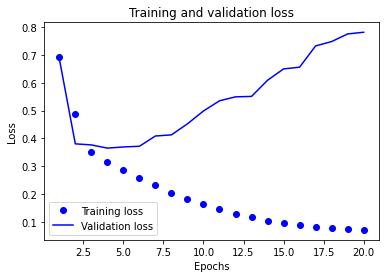

In [22]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

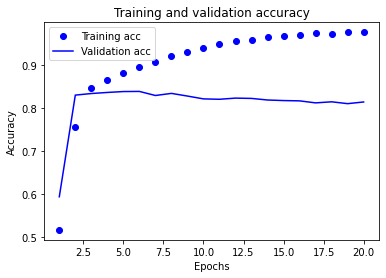

In [23]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

7) 학습된 Embedding 레이어 분석

In [24]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 300)


In [25]:
word_vector_dim = 16
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [26]:
word_vector_dim = 300
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [27]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
#word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True) # 오류가 떠서 다른 방법 이용함
word2vec = Word2Vec.load(word2vec_path)
vector = word2vec['영화']
vector

/tmp/ipykernel_482/2532425160.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['영화']


array([-1.7577837 , -1.0874279 ,  1.5300866 , -0.1115231 , -0.37980682,
        1.4828517 ,  1.3180419 ,  0.11094163,  0.7430535 , -0.45461136,
        0.58841336,  0.5763913 ,  1.210707  ,  1.3132795 , -0.86962503,
       -0.18507595, -0.47440064,  1.5100725 ,  1.0965794 ,  1.0600823 ,
       -0.27457932, -0.70003706,  2.3117511 ,  1.4944884 ,  0.25560892,
       -2.866659  , -0.28312334,  0.34263936, -0.67723423,  0.71714777,
        0.25549442,  0.71732044, -0.13262457,  0.01792452, -0.3184774 ,
        0.5271619 ,  0.7561084 , -2.1247065 ,  1.061429  , -0.21065854,
        0.6877343 , -1.4956383 ,  0.60346967, -2.6955893 ,  0.37694618,
       -1.0164185 ,  0.5430663 ,  0.1200121 , -2.6315718 ,  0.6216742 ,
        1.1583976 , -2.5385962 ,  1.326312  , -0.10284371, -0.0286147 ,
       -0.9132947 ,  0.7647564 ,  0.79202783, -1.8625957 , -0.7418395 ,
        0.5884277 , -0.9917992 , -0.62114453,  1.5367815 , -0.6628939 ,
        0.6712103 ,  0.12914915,  0.21228492,  0.9017655 , -0.25

In [28]:
word2vec.similar_by_word("행복")

/tmp/ipykernel_482/898241355.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("행복")


[('사랑', 0.6759077310562134),
 ('기쁨', 0.6493781805038452),
 ('즐거움', 0.6396492719650269),
 ('삶', 0.6299898028373718),
 ('젊음', 0.6187379360198975),
 ('즐겁', 0.6027448177337646),
 ('인생', 0.6002243161201477),
 ('존엄', 0.5952589511871338),
 ('고독', 0.5938762426376343),
 ('불행', 0.5894461870193481)]

In [29]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_482/4073186538.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_482/4073186538.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [30]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000   
word_vector_dim = 200  
LSTM_UNITS = 196
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS


kor_model = keras.Sequential()
kor_model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))   
kor_model.add(keras.layers.SpatialDropout1D(0.4))

kor_model.add(keras.layers.LSTM(LSTM_UNITS, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))  
kor_model.add(keras.layers.LSTM(LSTM_UNITS, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))  
kor_model.add(keras.layers.MaxPooling1D())
kor_model.add(keras.layers.GlobalMaxPooling1D())
kor_model.add(keras.layers.Dense(DENSE_HIDDEN_UNITS, activation='relu'))
kor_model.add(keras.layers.Dense(DENSE_HIDDEN_UNITS, activation='relu'))

kor_model.add(keras.layers.Dense(1, activation='sigmoid')) 

kor_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 41, 200)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 41, 196)           311248    
_________________________________________________________________
lstm_1 (LSTM)                (None, 41, 196)           308112    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 20, 196)           0         
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 196)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 784)              

In [32]:
callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

kor_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  

kor_history = kor_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    callbacks=callbacks,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
532/532 [==============================] - 187s 343ms/step - loss: 0.5061 - accuracy: 0.7403 - val_loss: 0.3788 - val_accuracy: 0.8312
Epoch 2/10
532/532 [==============================] - 178s 334ms/step - loss: 0.3828 - accuracy: 0.8252 - val_loss: 0.3383 - val_accuracy: 0.8512
Epoch 3/10
532/532 [==============================] - 176s 331ms/step - loss: 0.3459 - accuracy: 0.8461 - val_loss: 0.3268 - val_accuracy: 0.8590
Epoch 4/10
532/532 [==============================] - 175s 330ms/step - loss: 0.3236 - accuracy: 0.8568 - val_loss: 0.3162 - val_accuracy: 0.8619
Epoch 5/10
532/532 [==============================] - 175s 329ms/step - loss: 0.3091 - accuracy: 0.8652 - val_loss: 0.3094 - val_accuracy: 0.8672
Epoch 6/10
532/532 [==============================] - 175s 330ms/step - loss: 0.2968 - accuracy: 0.8710 - val_loss: 0.3080 - val_accuracy: 0.8668
Epoch 7/10
532/532 [==============================] - 173s 326ms/step - loss: 0.2867 - accuracy: 0.8761 - val_loss: 0.3160 -

In [33]:
results = kor_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 36s - loss: 0.3213 - accuracy: 0.8636
[0.3212503492832184, 0.8636003136634827]


In [34]:
kor_history_dict = kor_history.history
print(kor_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


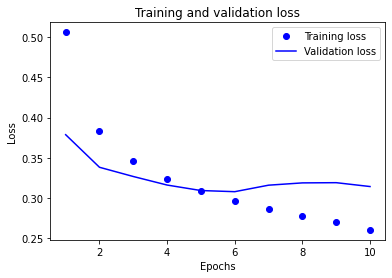

In [35]:
acc = kor_history_dict['accuracy']
val_acc = kor_history_dict['val_accuracy']
loss = kor_history_dict['loss']
val_loss = kor_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

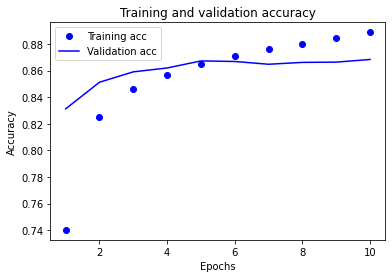

In [36]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

회고록 

코드 작성은 노드에 있는 내용을 참고하여 작성하여서, 크게 어려움은 없었다.
그리고 전체적인 흐름의 이해는 동아일보의 기고문을 통해서 감정 분석의 방법과 로직에 대해서 알게 되었다. 
그 기고문을 읽고 나니, 노드의 코드에 대해서 이해가 쉬웠다. 
그런데, gensim  버전 다운그레이드 후 인코딩 에러로 인해 애를 먹었다. 마침 오프모임이라, 영민님과 상옥님의 도움을 받아 해결하였다.

고생끝에 정확도가 0.8636으로 나와서 기뻤다. 